# Import Modules & Util Functions

In [56]:
import os
import sys
import glob
import re
import ast
import warnings

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter

import portion as P
import itertools as it
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


def data_loader(
    mode='sr',
    selected_dates=[],  excluded_dates=[],
    selected_exps=[],   excluded_exps=[],
    selected_routes=[], excluded_routes=[],
    query_dates=False, show_info=False,
    root_dir='/Users/jackbedford/Desktop/MOXA/Code/data'):
    
    # Collect experiment dates
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s not in ['backup']]
    
    if query_dates:
        if show_info:
            date_dirs = [os.path.join(root_dir, s) for s in dates]
            for date, date_dir in zip(dates, date_dirs):
                date = os.path.basename(date_dir)
                
                # Specify path to JSON file
                json_filepath = os.path.join(date_dir, f'{date}.json')
                
                # Read the JSON file and load its contents into a dictionary
                with open(json_filepath, 'r', encoding='utf-8') as json_file:
                    my_dict = json.load(json_file)
                
                # If the JSON file is empty, then continue
                if not my_dict:
                    continue
                
                print(date, len(my_dict))
                for exp, item in my_dict.items():
                    print({exp: item})
                
        return dates
    
    # Collect experiments
    date_dirs = [os.path.join(root_dir, s) for s in selected_dates if s not in excluded_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
                
        # Specify path to JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(selected_exps) != 0 and exp not in selected_exps:
                continue
            if len(excluded_exps) != 0 and exp in excluded_exps:
                continue
            if len(selected_routes) != 0 and item['route'] not in selected_routes:
                continue
            if len(excluded_routes) != 0 and item['route'] in excluded_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
    
    if show_info:            
        for date, exps in exps_dict.items():
            print(date, len(exps))
            for exp_name, exp in exps.items():
                print({exp_name: exp})
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv'),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('rrc.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('nr_ml1.csv')][0]),
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                combos = list(it.combinations(devices, 2))
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        _filepaths = []
                        for i in range(2):
                            _filepaths.append([
                                os.path.join(locals()[f'data_dir{i+1}'], 'handover_info_log.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_dnlk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_uplk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('rrc.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('nr_ml1.csv')][0]),
                            ])
                        filepaths.append(tuple(_filepaths))
    return filepaths

# DataLoader

In [57]:
def data_loader(
    mode='sr',
    selected_dates=[],  excluded_dates=[],
    selected_exps=[],   excluded_exps=[],
    selected_routes=[], excluded_routes=[],
    query_dates=False, show_info=False,
    root_dir='/Users/jackbedford/Desktop/MOXA/Code/data'):
    
    # Collect experiment dates
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s not in ['backup']]
    
    if query_dates:
        if show_info:
            date_dirs = [os.path.join(root_dir, s) for s in dates]
            for date, date_dir in zip(dates, date_dirs):
                date = os.path.basename(date_dir)
                
                # Specify path to JSON file
                json_filepath = os.path.join(date_dir, f'{date}.json')
                
                # Read the JSON file and load its contents into a dictionary
                with open(json_filepath, 'r', encoding='utf-8') as json_file:
                    my_dict = json.load(json_file)
                
                # If the JSON file is empty, then continue
                if not my_dict:
                    continue
                
                print(date, len(my_dict))
                for exp, item in my_dict.items():
                    print({exp: item})
                
        return dates
    
    # Collect experiments
    date_dirs = [os.path.join(root_dir, s) for s in selected_dates if s not in excluded_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
                
        # Specify path to JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(selected_exps) != 0 and exp not in selected_exps:
                continue
            if len(excluded_exps) != 0 and exp in excluded_exps:
                continue
            if len(selected_routes) != 0 and item['route'] not in selected_routes:
                continue
            if len(excluded_routes) != 0 and item['route'] in excluded_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
    
    if show_info:            
        for date, exps in exps_dict.items():
            print(date, len(exps))
            for exp_name, exp in exps.items():
                print({exp_name: exp})
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv'),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('rrc.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('nr_ml1.csv')][0]),
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                combos = list(it.combinations(devices, 2))
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        _filepaths = []
                        for i in range(2):
                            _filepaths.append([
                                os.path.join(locals()[f'data_dir{i+1}'], 'handover_info_log.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_dnlk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_uplk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('rrc.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('nr_ml1.csv')][0]),
                            ])
                        filepaths.append(tuple(_filepaths))
    return filepaths

In [58]:
dates = data_loader(query_dates=True)
filepaths = data_loader(mode='sr', selected_dates=[s for s in dates if s >= '2023-09-12'])
# print(len(filepaths))
# pprint(filepaths)
pprint(filepaths[0])

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv']


# DataAligner

In [59]:
def data_aligner(df, df_ho):
    if df_ho.empty:
        start = pd.Timestamp.max()
        end = pd.Timestamp.min()
    else:
        start = df_ho.iloc[0]['start'] - pd.Timedelta(seconds=10)
        end = df_ho.iloc[-1]['start'] + pd.Timedelta(seconds=10)
    print(start, end)
    df = df[(df['Timestamp'] >= start) & (df['Timestamp'] < end)]
    return df

# Dual Radio Modeling

In [48]:
import numpy as np
from sklearn.mixture import GaussianMixture

# 生成两组相互依赖的序列数据
# 这里假设数据服从两个高斯分布
data1 = np.random.normal(loc=5, scale=1, size=1000)
data2 = np.random.normal(loc=data1, scale=1, size=1000)

# 将数据转换为列向量
data1 = data1.reshape(-1, 1)
data2 = data2.reshape(-1, 1)

# 将两组数据合并
data = np.concatenate([data1, data2], axis=1)

# 使用混合高斯模型进行参数估计
gmm = GaussianMixture(n_components=2)  # 假设数据来自两个分布
gmm.fit(data)

# 输出每个分布的参数
for i in range(2):
    mean = gmm.means_[i]
    covariance = gmm.covariances_[i]
    print(f"Distribution {i+1}:")
    print("Mean:", mean)
    print("Covariance:", covariance)
    print()


Distribution 1:
Mean: [5.42296679 5.73035733]
Covariance: [[0.85279757 0.74504043]
 [0.74504043 1.52474947]]

Distribution 2:
Mean: [4.55103452 4.16166726]
Covariance: [[0.87199774 0.73608158]
 [0.73608158 1.4229355 ]]



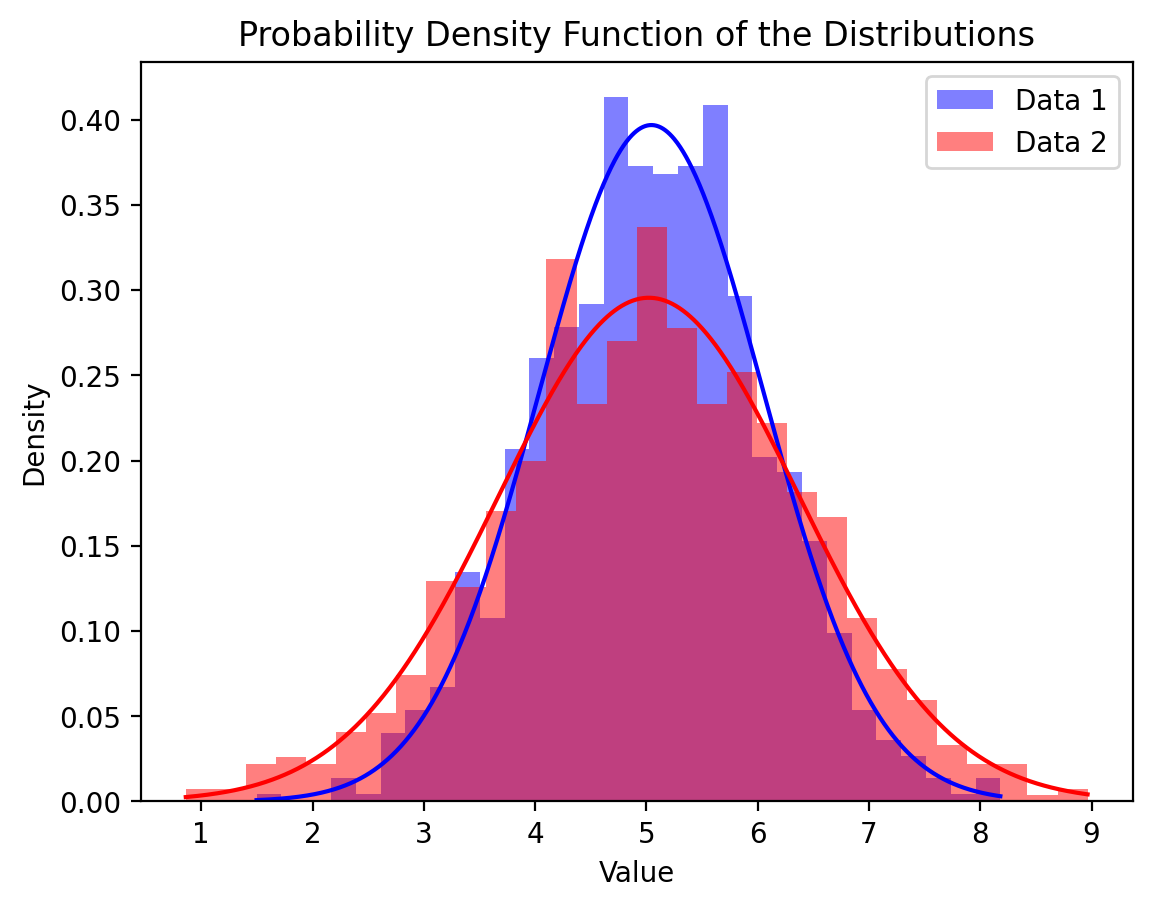

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 生成数据
data1 = np.random.normal(loc=5, scale=1, size=1000)
data2 = np.random.normal(loc=data1, scale=1, size=1000)

# 绘制第一个分布
plt.hist(data1, bins=30, density=True, alpha=0.5, color='blue', label='Data 1')

# 绘制第二个分布
plt.hist(data2, bins=30, density=True, alpha=0.5, color='red', label='Data 2')

# 绘制拟合曲线
x1 = np.linspace(min(data1), max(data1), 1000)
x2 = np.linspace(min(data2), max(data2), 1000)

plt.plot(x1, norm.pdf(x1, np.mean(data1), np.std(data1)), color='blue')
plt.plot(x2, norm.pdf(x2, np.mean(data2), np.std(data2)), color='red')

plt.title('Probability Density Function of the Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()


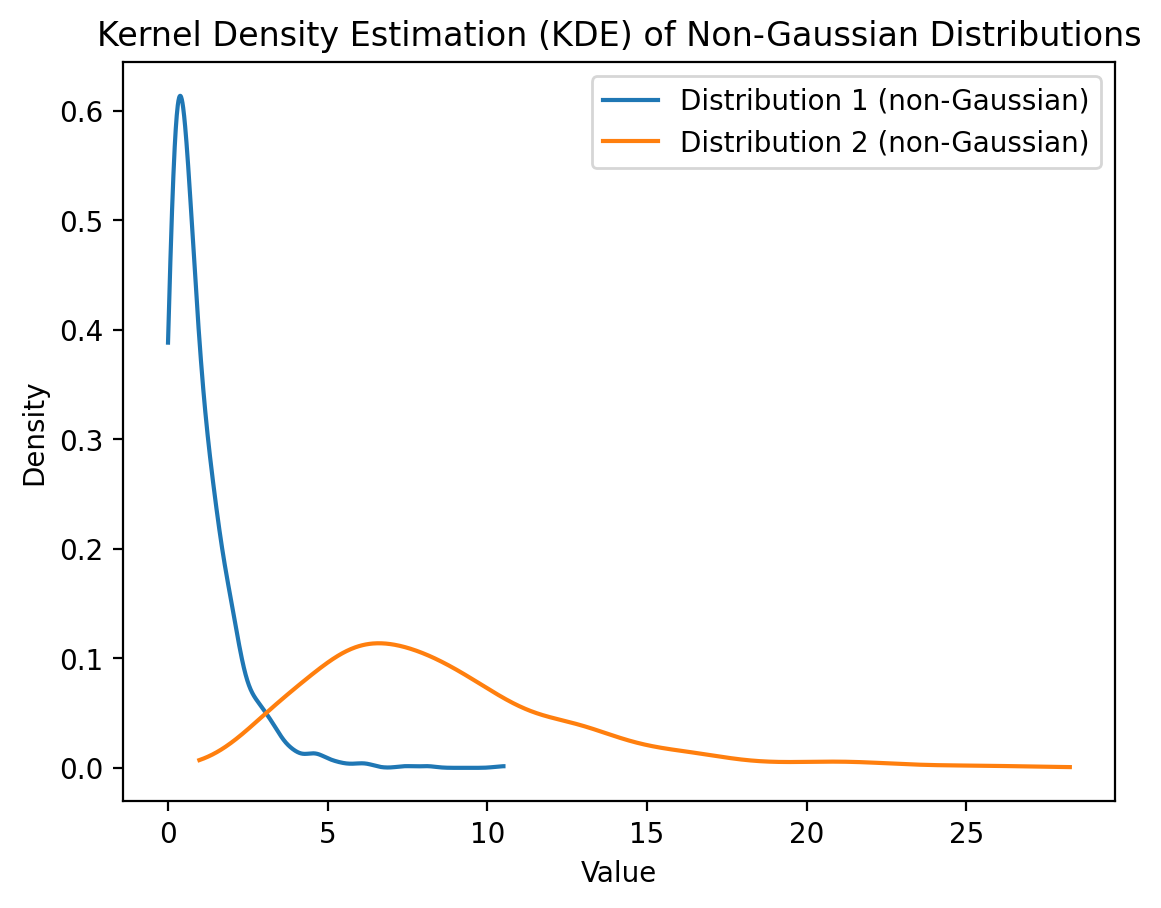

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 生成两组任意分布的示例数据
data1 = np.random.exponential(scale=1, size=1000)
data2 = np.random.lognormal(mean=2, sigma=0.5, size=1000)

# 使用核密度估计来估计数据的分布
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# 生成绘图用的数据
x1 = np.linspace(min(data1), max(data1), 1000)
x2 = np.linspace(min(data2), max(data2), 1000)
kde_values1 = kde1(x1)
kde_values2 = kde2(x2)

# 绘制分布图
plt.plot(x1, kde_values1, label='Distribution 1 (non-Gaussian)')
plt.plot(x2, kde_values2, label='Distribution 2 (non-Gaussian)')

plt.title('Kernel Density Estimation (KDE) of Non-Gaussian Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()


Covariance Matrix:
[[1.00797874 0.7762012 ]
 [0.7762012  0.96817305]]


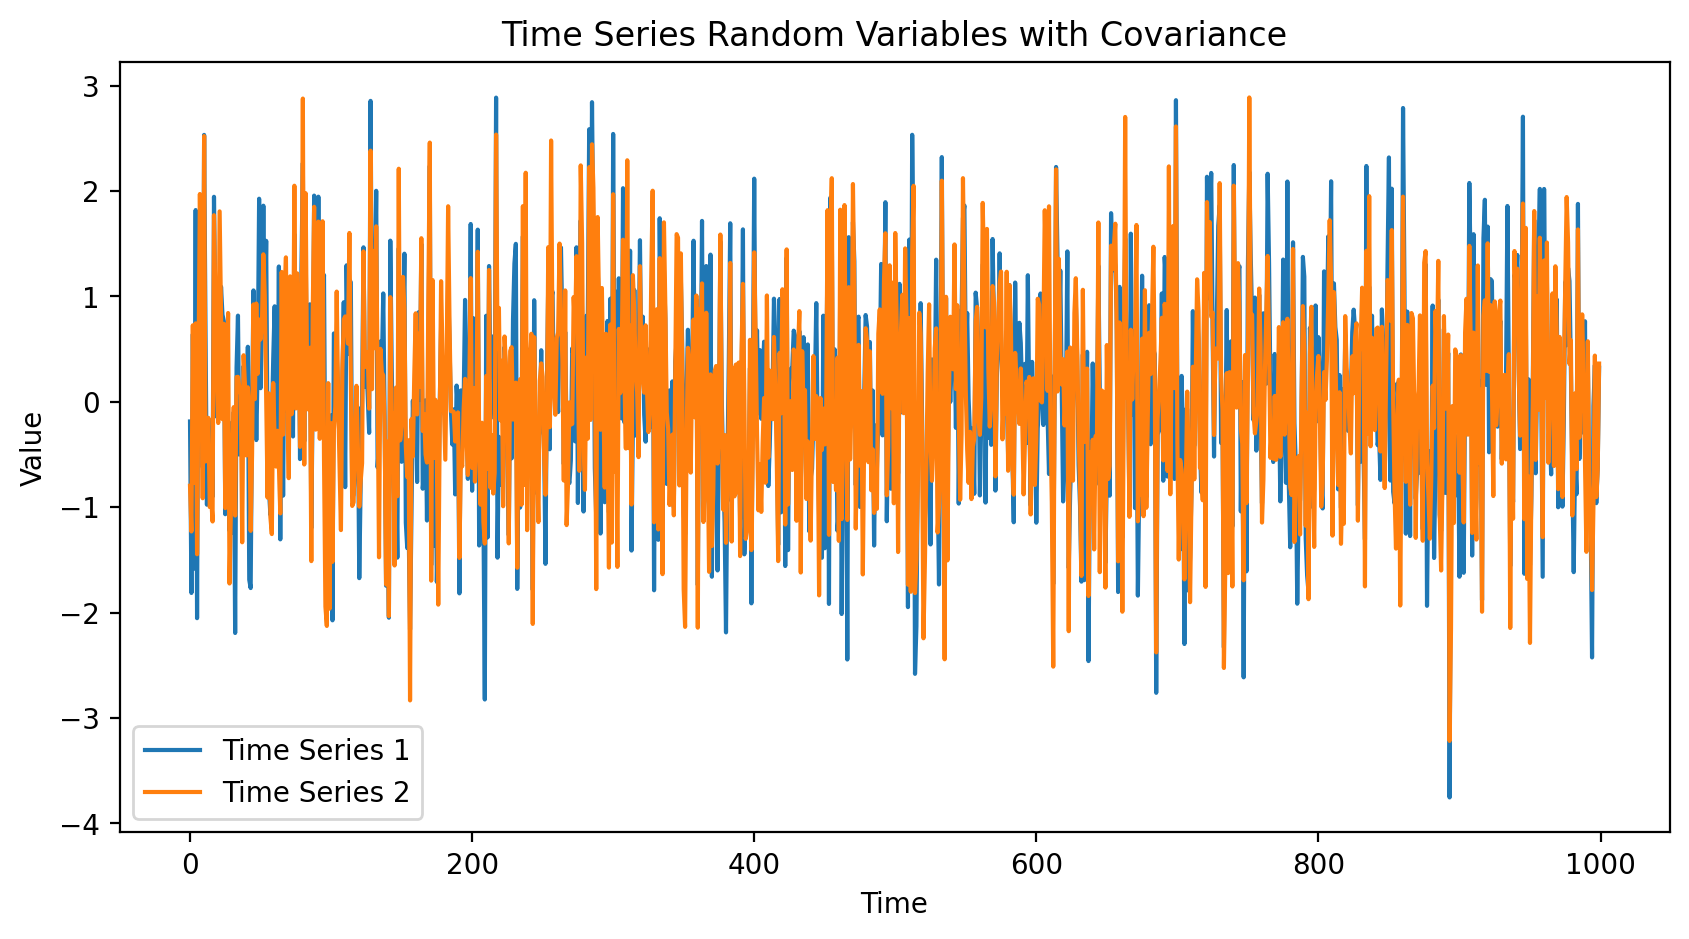

In [51]:
import numpy as np

# Parameters
num_samples = 1000  # Number of samples
mean = [0, 0]       # Mean of the distribution
covariance = [[1, 0.8], [0.8, 1]]  # Covariance matrix

# Generate multivariate normal distribution
data = np.random.multivariate_normal(mean, covariance, num_samples)

# Extract the two time series from the multivariate normal distribution
time_series1 = data[:, 0]
time_series2 = data[:, 1]

# Print covariance matrix
print("Covariance Matrix:")
print(np.cov(time_series1, time_series2))

# Plot the time series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(time_series1, label='Time Series 1')
plt.plot(time_series2, label='Time Series 2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Random Variables with Covariance')
plt.legend()
plt.show()


/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


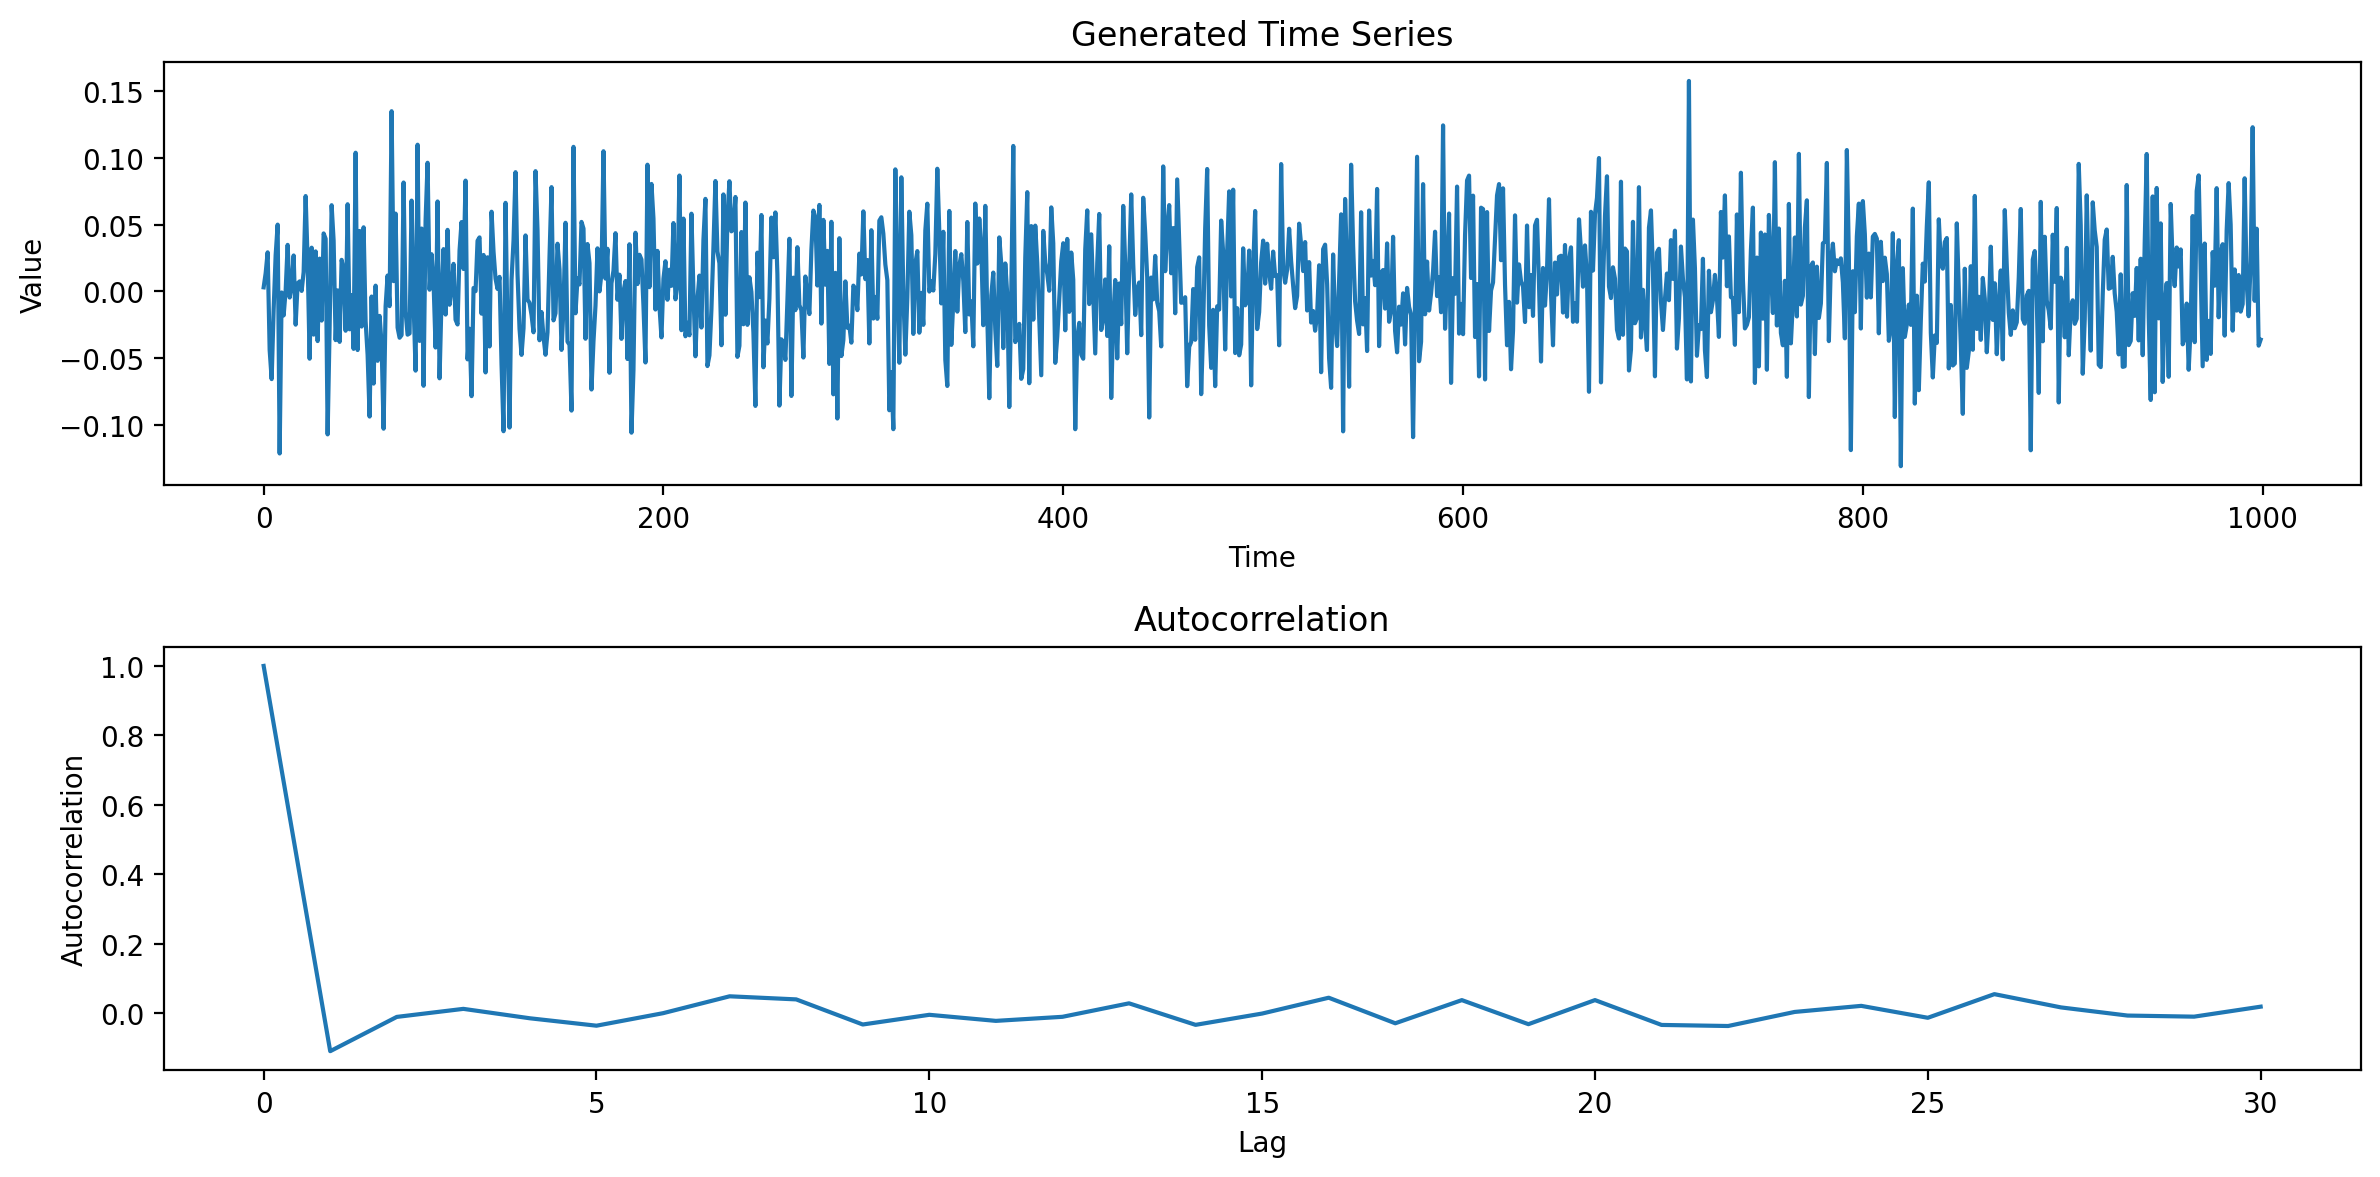

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Parameters
num_samples = 1000  # Number of samples
p = 2               # Order of autoregressive component
q = 1               # Order of moving average component
correlation = 0.8   # Desired correlation between successive time points

# Generate white noise series
white_noise = np.random.normal(size=num_samples)

# Generate ARIMA model with specified correlation
arima_model = sm.tsa.ARIMA(white_noise, order=(p, 0, q))  # ARIMA(p, d, q) where d is the order of differencing (0 for this case)
time_series = arima_model.fit().predict()

# Calculate autocorrelation of the generated time series
autocorrelation = sm.tsa.stattools.acf(time_series)

# Plot the time series and autocorrelation
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_series)
plt.title('Generated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(2, 1, 2)
plt.plot(autocorrelation)
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate example time series data
np.random.seed(0)
num_samples = 1000
data1 = np.random.normal(loc=0, scale=1, size=num_samples)
data2 = 0.5 * data1 + np.random.normal(loc=0, scale=0.5, size=num_samples)

# Fit VARMA model to the data
order = (1, 1)  # Order of the VARMA model (p, q)
model = sm.tsa.VARMAX([data1, data2], order=order)
result = model.fit(disp=False)

# Print model summary
print(result.summary())

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data1, label='Data 1')
plt.plot(data2, label='Data 2')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LinAlgError: 1-dimensional array given. Array must be two-dimensional

/Users/jackbedford/opt/anaconda3/envs/moxa/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                 1000
Model:                     VARMA(1,1)   Log Likelihood               -2097.346
                          + intercept   AIC                           4220.693
Date:                Mon, 19 Feb 2024   BIC                           4284.494
Time:                        13:19:25   HQIC                          4244.942
Sample:                             0                                         
                               - 1000                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):           0.36, 0.98
Prob(Q):                        0.97, 0.95   Prob(JB):                   0.84, 0.61
Heteroskedasticity (H):         0.98, 1.06   Skew:                       0.04, 0.05
Prob(H) (two-sided):            0.83,

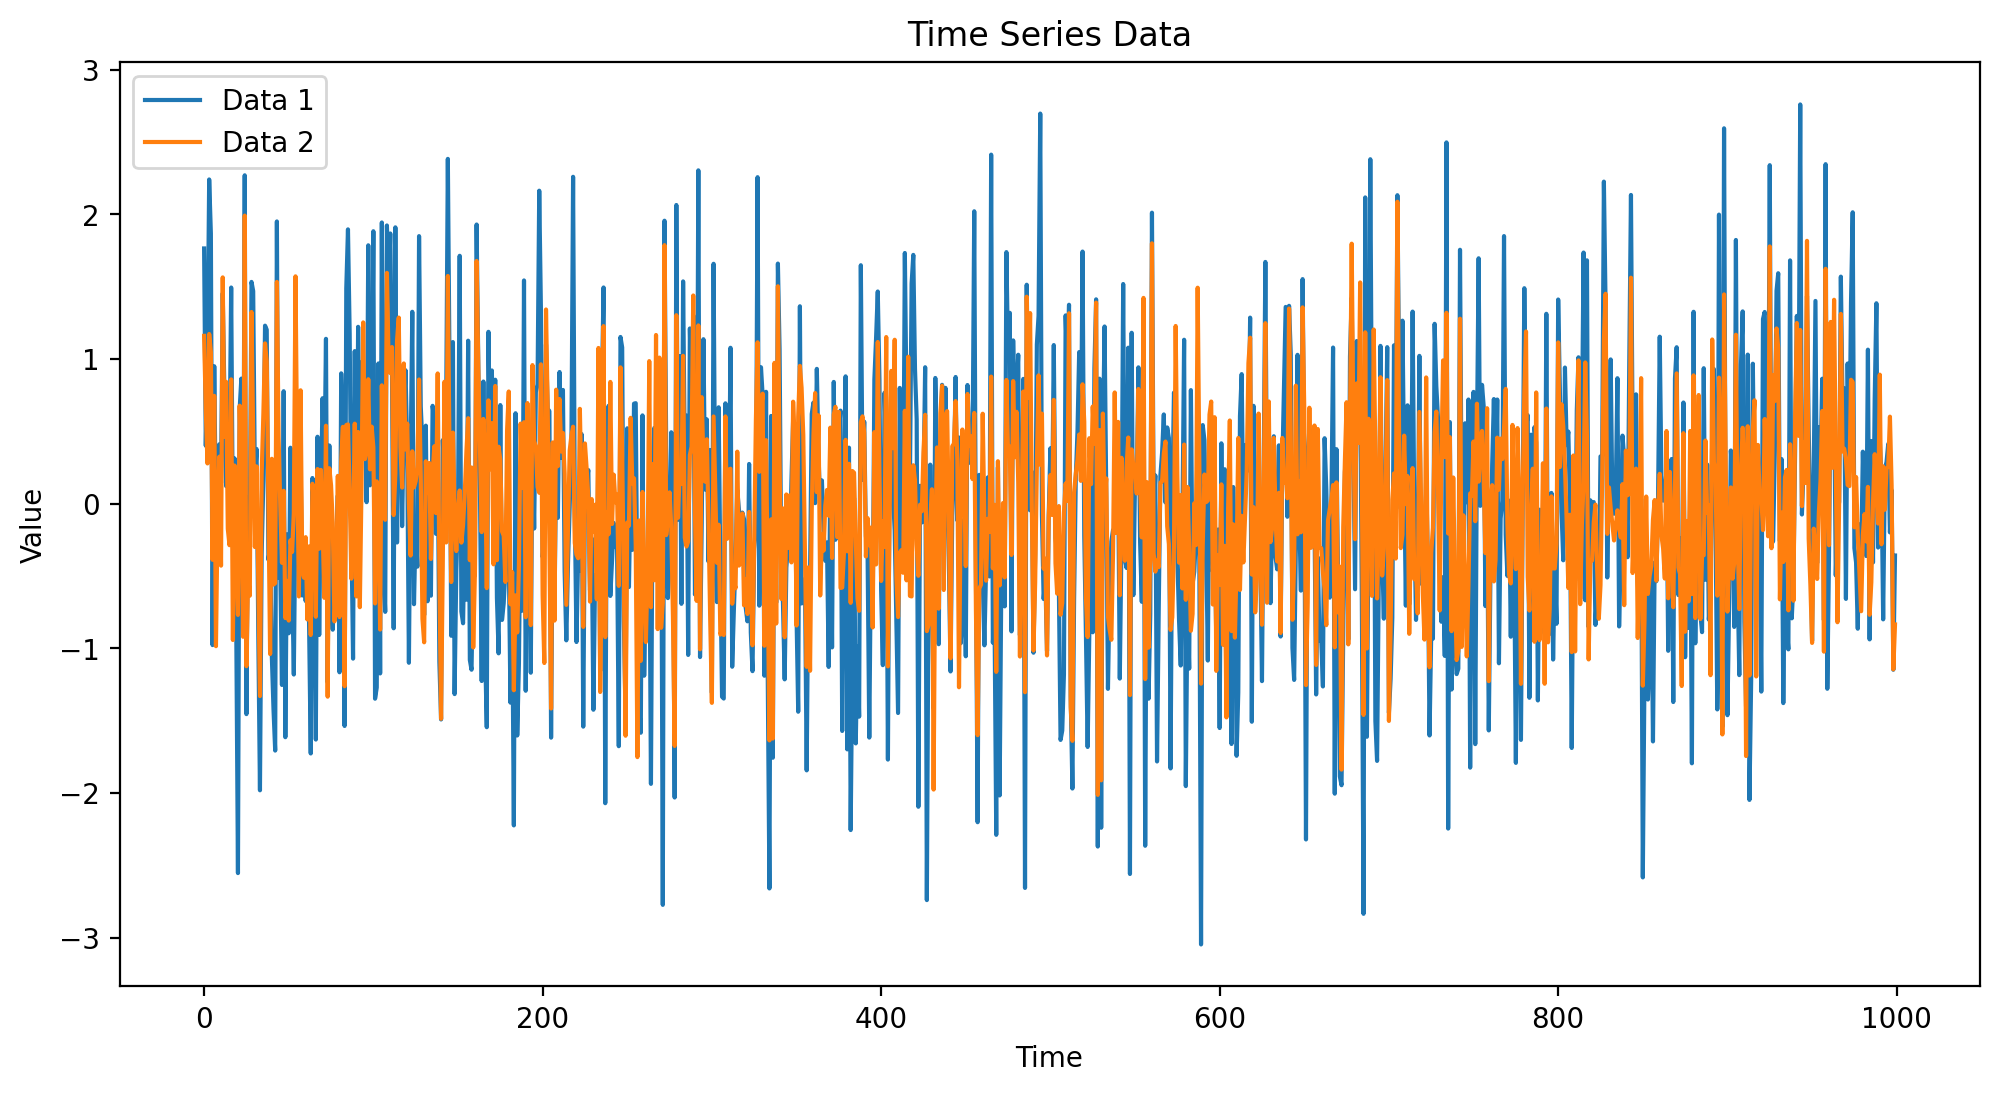

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate example time series data
np.random.seed(0)
num_samples = 1000
data1 = np.random.normal(loc=0, scale=1, size=num_samples)
data2 = 0.5 * data1 + np.random.normal(loc=0, scale=0.5, size=num_samples)

# Combine the two time series data into a 2D array
data = np.column_stack((data1, data2))

# Fit VARMA model to the data
order = (1, 1)  # Order of the VARMA model (p, q)
model = sm.tsa.VARMAX(data, order=order)
result = model.fit(disp=False)

# Print model summary
print(result.summary())

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data1, label='Data 1')
plt.plot(data2, label='Data 2')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [63]:
dates = data_loader(query_dates=True)
filepaths = data_loader(mode='dr', selected_dates=[s for s in dates if s >= '2023-09-12'])
# print(len(filepaths))
# pprint(filepaths)
filepath = filepaths[0]
pprint(filepath)

(['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UD

In [64]:
df_ho1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
df_ho2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
df1 = data_aligner(df1, df_ho1)
df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
df2 = data_aligner(df2, df_ho2)
df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})

2023-09-12 13:32:03.330518 2023-09-12 14:21:06.658771
2023-09-12 13:32:30.487561 2023-09-12 14:21:06.933084


In [66]:
df2

,seq,rpkg,frame_id,Timestamp,lost,excl,latency,xmit_time,arr_time
0,2501,4.0,3509.0,2023-09-12 13:34:16.245625,False,False,0.006932,2023-09-12 13:34:16.245656,2023-09-12 13:34:16.252557443
1,2502,3.0,3513.0,2023-09-12 13:34:16.247625,False,False,0.010498,2023-09-12 13:34:16.247636,2023-09-12 13:34:16.258123443
2,2503,3.0,3513.0,2023-09-12 13:34:16.249625,False,False,0.008498,2023-09-12 13:34:16.249636,2023-09-12 13:34:16.258123443
3,2504,3.0,3513.0,2023-09-12 13:34:16.251626,False,False,0.006497,2023-09-12 13:34:16.251636,2023-09-12 13:34:16.258123443
4,2505,3.0,3517.0,2023-09-12 13:34:16.253626,False,False,0.010151,2023-09-12 13:34:16.253638,2023-09-12 13:34:16.263777443
...,...,...,...,...,...,...,...,...,...
1405274,1407775,3.0,1849329.0,2023-09-12 14:21:06.924962,False,False,-0.000960,2023-09-12 14:21:06.924980,2023-09-12 14:21:06.924002443
1405275,1407776,3.0,1849329.0,2023-09-12 14:21:06.926962,False,False,-0.002960,2023-09-12 14:21:06.926976,2023-09-12 14:21:06.924002443
1405276,1407777,3.0,1849333.0,2023-09-12 14:21:06.928963,False,False,0.001073,2023-09-12 14:21:06.928972,2023-09-12 14:21:06.930036443
1405277,1407778,3.0,1849333.0,2023-09-12 14:21:06.930963,False,False,-0.000927,2023-09-12 14:21:06.930976,2023-09-12 14:21:06.930036443


In [68]:
import numpy as np

# 参数设置
num_trials = 1000  # 试验次数
p = 0.3  # 第一个分布的成功概率
success_prob_when_first_is_success = 0.8  # 第二个分布在第一个分布为成功时的成功概率
success_prob_when_first_is_failure = 0.2  # 第二个分布在第一个分布为失败时的成功概率

# 生成第一个分布
first_distribution_samples = np.random.binomial(n=1, p=p, size=num_trials)

# 生成第二个分布
second_distribution_samples = np.where(first_distribution_samples == 1, 
                                        np.random.binomial(n=1, p=success_prob_when_first_is_success, size=num_trials),
                                        np.random.binomial(n=1, p=success_prob_when_first_is_failure, size=num_trials))

# 计算结果
num_successes = np.sum(second_distribution_samples)
success_rate = num_successes / num_trials

print(f"Total number of successes: {num_successes}")
print(f"Success rate: {success_rate}")


Total number of successes: 378
Success rate: 0.378


In [69]:
from scipy.optimize import minimize
import numpy as np

# 生成的数据
data = {
    'first_distribution_samples': np.array(first_distribution_samples),  # 第一个分布的样本数据
    'second_distribution_samples': np.array(second_distribution_samples)  # 第二个分布的样本数据
}

# 定义似然函数
def likelihood(params, data):
    p, success_prob_when_first_is_success, success_prob_when_first_is_failure = params
    first_samples = data['first_distribution_samples']
    second_samples = data['second_distribution_samples']
    likelihood = 1.0
    for first_sample, second_sample in zip(first_samples, second_samples):
        if first_sample == 1:
            likelihood *= success_prob_when_first_is_success if second_sample == 1 else (1 - success_prob_when_first_is_success)
        else:
            likelihood *= success_prob_when_first_is_failure if second_sample == 1 else (1 - success_prob_when_first_is_failure)
    return -np.log(likelihood)  # 取负对数似然函数，因为我们要最大化似然函数

# 使用最大似然估计估算参数
initial_guess = [0.5, 0.5, 0.5]  # 初始猜测值
result = minimize(likelihood, initial_guess, args=(data,), method='Nelder-Mead')

# 输出估计的参数值
estimated_params = result.x
print("Estimated parameters:")
print(f"p: {estimated_params[0]}")
print(f"success_prob_when_first_is_success: {estimated_params[1]}")
print(f"success_prob_when_first_is_failure: {estimated_params[2]}")


Estimated parameters:
p: 0.5116385283305542
success_prob_when_first_is_success: 0.8059259496833258
success_prob_when_first_is_failure: 0.19109010197719228
